# Приоритизация гипотез и анализ A/B-теста

Целью данного проекта является анализ гипотез, подготовленных аналитиками и отделом маркетинга для увеличения выручки крупного интернет-магазина. Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса (в данном случае выручку), сформулированные гипотезы необходимо приоритизировать, а также провести A/B-тест, чтобы точно измерить эффект от внедрения изменения. 

Полученные результаты приоритезации и A/B-теста необходимо будет также проанализировать и интерпретировать.

Для приоритезации в нашем ряспоряжении имеется файл `/datasets/hypothesis.csv` со следующими данными:

`Hypothesis` — краткое описание гипотезы;
`Reach` — охват пользователей по 10-балльной шкале;
`Impact` — влияние на пользователей по 10-балльной шкале;
`Confidence` — уверенность в гипотезе по 10-балльной шкале;
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Для проведения A/B-теста будем использовать файлы `/datasets/orders.csv` со следующими данными:
`transactionId` — идентификатор заказа;
`visitorId` — идентификатор пользователя, совершившего заказ;
`date` — дата, когда был совершён заказ;
`revenue` — выручка заказа;
`group` — группа A/B-теста, в которую попал заказ;

а также `/datasets/visitors.csv` с данными:
`date` — дата;
`group` — группа A/B-теста;
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

На первом этапе работы ознакомимся с датасетами и выполним предобработку, если она понадобится.
Затем осуществим приоритезацию гипотез и проведем А/В тест.

**Шаг 1. Загрузка и предобработка данных**

Импортируем библиотеки, которые могут понадобиться нам в ходе работы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
import calendar
import seaborn as sns
from scipy import stats as stats
from math import sqrt
from importlib import reload
from datetime import datetime, timedelta

Загрузим и ознакомимся с 3 предоставленными файлами

In [2]:
hypothesis=pd.read_csv('/datasets/hypothesis.csv')
orders=pd.read_csv('/datasets/orders.csv')
visits=pd.read_csv('/datasets/visitors.csv')

In [3]:
# Выведем общую информацию о 3 датасетах:
hypothesis.info()
orders.info()
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

In [4]:
# Для ознакомления также просмотрим первые 5 строчек наших данных:
display(hypothesis.head())
display(orders.head())
display(visits.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Из общей информации видно, что столбцы `date` в данных о заказах и визитах имеют неправильный формат. Это необходимо исправить, преобразовав столбцы в формат `datetime`.

In [5]:
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

#С помощью метода info() убедимся, что формат изменен:
orders.info()
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [6]:
# Проверим наличие пропусков в каждом столбце:
display(hypothesis.isna().sum())
display(orders.isna().sum())
display(visits.isna().sum())
# Пропуски отсутствуют

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

In [7]:
# Проверим наличие явных дубликатов:
display(hypothesis.duplicated().sum())
display(orders.duplicated().sum())
display(visits.duplicated().sum())
# Полностью повторяющиеся строки отсутствуют

0

0

0

In [8]:
hypothesis['Hypothesis'].nunique()
# В наших данных 9 уникальных гипотез

orders['transactionId'].nunique()
# В наших данных 1197 уникальных идентификаторов заказа

orders['visitorId'].nunique()
# В наших данных 1031 уникальных идентификаторов пользователей, совершивших заказ; значит, некоторые пользователи совершали несколько заказов.

# Проверим, за какой период мы проводим исследование:
print(visits['date'].min())
print(visits['date'].max())

print(orders['date'].min())
print(orders['date'].max())


2019-08-01 00:00:00
2019-08-31 00:00:00
2019-08-01 00:00:00
2019-08-31 00:00:00


**Вывод к Шагу 1**

На Шаге 1 мы изучили 3 датасета о гипотезах, а также заказах и посещениях, которые мы используем для осуществления A/В теста. У нас есть 9 уникальных гипотез, 1197 уникальных идентификаторов заказа и 1031 уникальных идентификаторов пользователей. Данные предоставлены за август 2019 года. Полностью повторяющиеся строки отсутствуют, формат столбцов `date` изменен.

# Шаг 2. Приоритезация гипотез.

Воспользуемся двумя способами приоритизации гипотез: ICE и RICE.

In [9]:
# Приоритезация гипотез методом ICE, учитывая показатели impact, confidence, effort/"влияние, уверенность, усилия / простота":
hypothesis['ICE']=hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']
hypothesis
pd.set_option('display.max_colwidth', 0)

In [10]:
hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы по ICE: 8,0,7

In [11]:
# Приоритезация гипотез методом RICE, учитывая четыре компонента:
# Reach — скольких пользователей затронет изменение, которое вы хотите внести;
# Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
# Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
# Efforts — сколько стоит протестировать эту гипотезу. 

hypothesis['RICE']=hypothesis['Impact']*hypothesis['Confidence']*hypothesis['Reach']/hypothesis['Efforts']
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


In [12]:
hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6

**Промежуточный вывод к Шагу 2**

Наиболее перспективные гипотезы по ICE: 8,0,7. Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6. Приоритизация гипотез при применении RICE вместо ICE изменилась. Возможная причина - показатель количества пользователей, который мы учитываем при приоритезации методом RICE. Например, у гипотезы 7 этот показатель выше (Reach=10), чем у гипотезы 8 (Reach=1).

# Шаг 3. Анализ A/B-теста

**1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.**

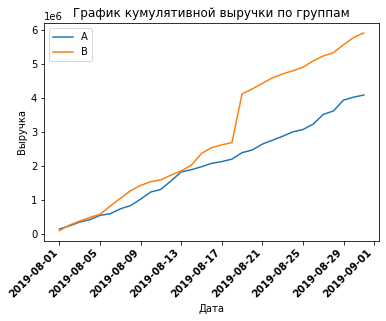

<Figure size 360x576 with 0 Axes>

In [13]:
# Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. Избавимся от дубликатов методом drop_duplicates().
datesGroups = orders[['date','group']].drop_duplicates() 

# Объявим переменную ordersAggregated, содержащую: дату; 
# группу A/B-теста; 
# число уникальных заказов в группе теста по указанную дату включительно; 
# число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно; 
# суммарную выручку заказов в группе теста по указанную дату включительно
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])


# Объявим переменную visitorsAggregated, содержащую:
# дату;
# группу A/B-теста;
# количество уникальных посетителей в группе теста по указанную дату включительно
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Определим переменную cumulativeData, объединив ordersAggregated и visitorsAggregated по колонкам 'date', 'group' методом merge()
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

# Присвоим столбцам cumulativeData названия ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График кумулятивной выручки по группам')
plt.xticks(color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
plt.figure(figsize=(5,8))
plt.show()

В начале исследуемого периода сегмент B и A были наравных. Затем сегмент B "вырвался" вперед и продолжал лидировать весь остаток теста. Необхолимо также проверить, были ли аномальные заказы, которые могли повлиять на результаты.

**2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.**

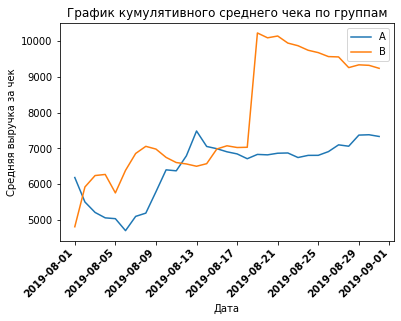

<Figure size 360x576 with 0 Axes>

In [14]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 

plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Средняя выручка за чек')
plt.title('График кумулятивного среднего чека по группам')
plt.xticks(color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
plt.figure(figsize=(5,8))
plt.show()

Кумулятивное значение среднего чека колеблется в первой половине периода для обеих групп. Во второй половине периода среднее значение по группе А было более стабильным. Опять же, в группу B могли попасть слишком дорогие заказы, что может объяснить резкий рост на графике.

**3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.**

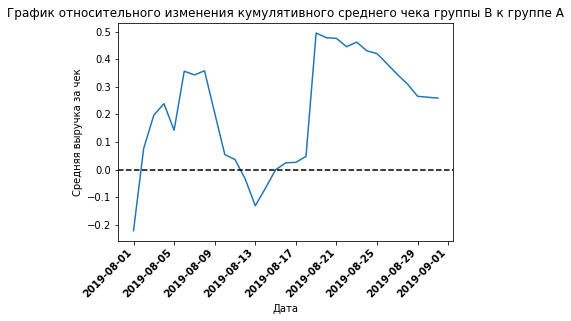

<Figure size 360x576 with 0 Axes>

In [15]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')


plt.xlabel('Дата')
plt.ylabel('Средняя выручка за чек')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
plt.figure(figsize=(5,8))
plt.show()


Резкие колебания заметны в середине месяца. Возможно, тогда и были совершены аномальньные заказы.

**4. Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.**

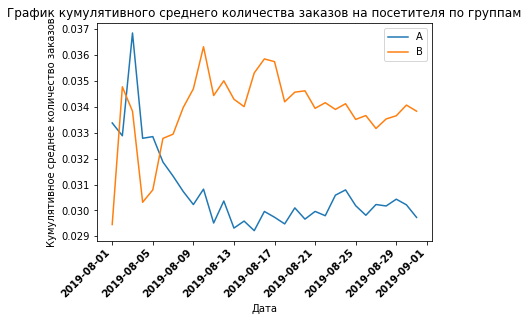

<Figure size 360x576 with 0 Axes>

In [16]:
# считаем кумулятивную среднее количество заказов
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xticks(color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
plt.figure(figsize=(5,8))
plt.show()

Конверсия группы А сначала выше, чем у В. Однако чуть позже конверсия В резко увеличилась и больше не снижалась до уровна А или ниже. Попробуем устаносить масштаб осей.

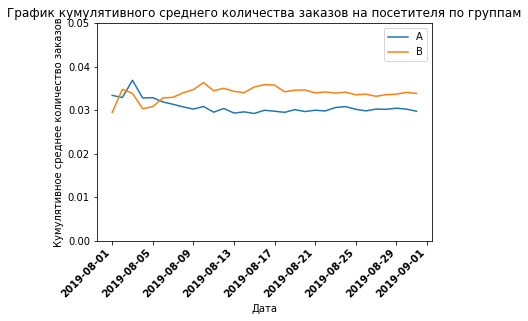

<Figure size 360x576 with 0 Axes>

In [17]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.ylim(0, 0.05)

plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xticks(color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
plt.figure(figsize=(5,8))
plt.show()

Изменив масштаб, видно, что колебания были не такими сильными: от 3 до чуть менее 4%. 

**5. Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.**

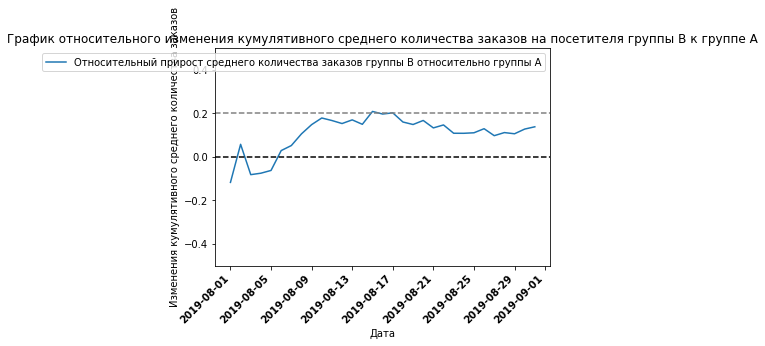

<Figure size 360x576 with 0 Axes>

In [18]:
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост среднего количества заказов группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Изменения кумулятивного среднего количества заказов')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylim(-0.5, 0.5)
plt.xticks(color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
plt.figure(figsize=(5,8))
plt.show()

Конверсия группы В лидирует почти с начала теста и находится примерно на уровне 20% прироста относительно группы А к середине месяца. Затем уровень немного опустился до уровня 10-15%.

**6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.**

Text(0.5, 1.0, 'График количества заказов по пользователям')

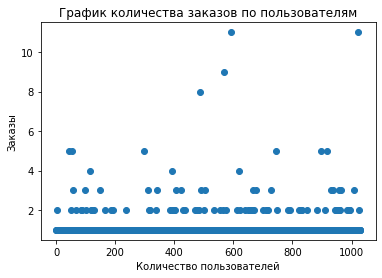

In [19]:
# Посчитаем количество заказов по пользователям и построим точечную диаграмму: 
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 

plt.xlabel('Количество пользователей')
plt.ylabel('Заказы')
plt.title('График количества заказов по пользователям')

В основном пользователи совершали по 1 заказу. Также популярны были объемы заказов в размере 2-5. Их точная доля не ясна. Необходимо понять, стоит ли считать их аномалиями или нет. Аномалиями пока выглядят заказы в количестве от 8.
Посчитаем выборочные перцентили количества заказов на одного пользователя.

**7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.**

In [20]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше 2 заказов.  Не более 1% пользователей оформляли больше 4 заказов.

Предлагается выбрать 4 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

**8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.**

Text(0.5, 1.0, 'График стоимостей заказов')

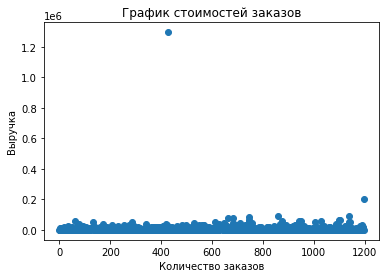

In [21]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.xlabel('Количество заказов')
plt.ylabel('Выручка')
plt.title('График стоимостей заказов')

Наибольшая часть стоимости заказов не превышает отметку примерно в 100 000. Есть выбросы в данных - заказ на сумму более 1 200 000, а также заказ на сумму около 200 000. Необходимо посчитать перцентили стоимости заказов, чтобы определить показатели точнее.

**9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.**

In [22]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов были дороже 28 000.  Не более 1% заказов были дороже 58 233.

Предлагается выбрать сумму заказа 58 233 за верхнюю границу и отсеять аномальных пользователей по ней.

**10. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.**

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя без удаления аномальных данных.

Сформулируем гипотезы. H0: различий в среднем количестве заказов на посетителя между группами по "сырым" данным нет. H1: различия в среднем между группами по "сырым" данным есть. 

Здесь и далее используемый критический уровень статистической значимости alpha=0,05

In [23]:
#  Сначала подготовим данные и получим таблицу со следующими данными:
# количеством заказов в выбранную дату в группе A;
# суммарной выручкой в выбранную дату в группе A;
# количеством заказов в выбранную дату в группе B;
# суммарной выручкой в выбранную дату в группе B;
# суммарноым числом заказов до выбранной даты включительно в группе A;
# суммарной выручкой до выбранной даты включительно в группе A;
# суммарным количество заказов до выбранной даты включительно в группе B;
# суммарной выручкой до выбранной даты включительно в группе B;
# количеством пользователей в выбранную дату в группе A;
# количеством пользователей в выбранную дату в группе B;
# количеством пользователей до выбранной даты включительно в группе A;
# количеством пользователей до выбранной даты включительно в группе B.

visitorsADaily = visits[visits['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visits[visits['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# Таблицу подготовили

# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsersB.columns = ['userId', 'orders']

# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.
# Переменная sampleA должна состоять из двух частей:
# список с количеством заказов для каждого из пользователей: ordersByUsersA['orders'];
# нули для пользователей, которые ничего не заказывали. 
# Их количество равно разнице между суммой посетителей и количеством записей о заказах: data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']). 
# Создадим объект pd.Series нужной длины:

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


# Число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. 
# Чтобы получить среднее число заказов на пользователя, поделим сумму заказов на число пользователей
# Найдём среднее в выборке sampleA методом mean(). Аналогично найдём среднее группы B: SampleB.mean().

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим статистический критерий Манна-Уитни к полученным выборкам 
# Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


0.01679
0.138


Первое число 0,017 (P-value) меньше критического уровня статистической значимости alpha = 0,05. У нас есть основания отвергнуть нулевую гипотезу о том, что различий в среднем количестве заказов между группами нет. Анализ "сырых" данных говорит о том, что относительный прирост среднего группы B к среднему количеству заказов группы А равен 13,8%.

**11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.**

Сформулируем гипотезы. H0: различий в среднем чеке заказа между группами по "сырым" данным нет. H1: различия в среднем чеке между группами по "сырым" данным есть. 

Здесь и далее используемый критический уровень статистической значимости alpha=0,05

In [24]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


Первое число 0,73 (P-value) больше критического уровня статистической значимости alpha = 0,05. Нет оснований отвергнуть нулевую гипотезу о том, что различий в среднем чеке заказа между группами по «сырым» данным нет. Относительное различие среднего чека между сегментами 25,9% в пользу сегмента В. 

**12. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.**

Ранее были выбраны следующие верхние границы для работы с аномальными данными: 4 заказа на одного пользователя и сумма заказа 58 233.

Сформулируем гипотезы. H0: различий в среднем количестве заказов на посетителя между группами по "очищенным" данным нет. H1: различия в среднем между группами по "очищенным" данным есть. 

Здесь и далее используемый критический уровень статистической значимости alpha=0,05

In [25]:
# Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, 
# совершивших заказы дороже 58 233 — usersWithExpensiveOrders. 
# Объединим их в таблице abnormalUsers, удалив дубликаты и сортируя по возрастанию. 

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
len(abnormalUsers)

15

У нас 15 "аномальных" пользователей

In [26]:
# Посчитаем статистическую значимость различия среднего количества заказов после удаления аномальных пользователей.
# Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах, не включая аномальных пользователей. 
# Затем выведем p-value для сравнения среднего между очищенными группами. 
# Округлим p-value, выведем относительный прирост среднего очищенной группы B.

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01438
0.153


Первое число 0,014 (P-value) меньше критического уровня статистической значимости alpha = 0,05. Есть основания отвергнуть нулевую гипотезу о том, что различий в среднем количестве заказов на посетителя между группами по «очищенным» данным нет. Относительное различие  среднего количества заказов на посетителя между сегментами В по отношению к сегменту А составило 15,3%. 

**13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.**

Сформулируем гипотезы. H0: различий в среднем чеке заказа между группами по "очищенным" данным нет. H1: различия в среднем чеке между группами по "очищенным" данным есть. 
Здесь и далее используемый критический уровень статистической значимости alpha=0,05

In [27]:
# Выведем p-value для сравнения средних чеков между очищенными группами. 
# Округлим p-value, выведем относительный прирост среднего чека очищенной группы B.

print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.851
-0.006


P-value больше критического уровня статистической значимости alpha = 0,05. Нет оснований отвергнуть нулевую гипотезу о том, что различий в среднем чеке заказа между группами по «очищенным» данным нет. Относительное различие среднего чека между сегментами В по отношению к сегменту А ниже на 0,6%. 

**14. Примите решение по результатам теста и объясните его. Варианты решений:**
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.


При анализе "очищенных" данных относительное различие среднего чека между сегментами В по отношению к сегменту А ниже на 1,4%. При аналогичном анализе по "сырым" данным относительное различие среднего чека между сегментами 25,9% в пользу сегмента В. Проверив гипотезы, выяснилось, что по сырым данным нет статистически значимого различия по среднему чеку между группами. После удаления аномалий статистически значимого различия также нет.

Относительное различие среднего количества заказов на посетителя между сегментами В по отношению к сегменту А составило 15,1% по "очищенным" данным. Анализ "сырых" данных говорит о том, что относительный прирост среднего группы B к среднему количеству заказов группы А равен 13,8%. Есть статистически значимое различие по среднему количеству заказов между группами как по сырым данным, так и после фильтрации аномалий. 

Вследствие того, что есть статистически значимое различие по среднему количеству заказов между группами как по сырым данным, так и после фильтрации аномалий, то можно утверждать, что результаты группы B лучше группы А.

Предлагается остановить тест, признать его успешным. 

# Вывод

Целью данного проекта являлся анализ гипотез, подготовленных аналитиками и отделом маркетинга для увеличения выручки крупного интернет-магазина. Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса (в данном случае выручку), сформулированные гипотезы необходимо было приоритизировать, а также провести A/B-тест, чтобы точно измерить эффект от внедрения изменения.

На Шаге 1 мы изучили 3 датасета о гипотезах, а также заказах и посещениях, которые мы использовали для осуществления A/В теста. У нас было 9 уникальных гипотез, 1197 уникальных идентификаторов заказа и 1031 уникальных идентификаторов пользователей. Данные предоставлены за август 2019 года. Осуществлена предобработка: полностью повторяющиеся строки отсутствовали, формат столбцов `date` был изменен.

Затем на Шаге 2 мы осуществили приоритезацию гипотез. Применили фреймворк ICE, RICE для приоритизации гипотез. Наиболее перспективные гипотезы по ICE: 8,0,7. Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6. Приоритизация гипотез при применении RICE вместо ICE изменилась. Возможная причина - показатель количества пользователей, который мы учитываем при приоритезации методом RICE. Например, у гипотезы 7 этот показатель выше (Reach=10), чем у гипотезы 8 (Reach=1).

На Шаге 3 быд проведен А/В тест. Были построены графики кумулятивной выручки по группам и кумулятивного среднего чека по группам. Что касается кумулятивной выручки, то в начале исследуемого периода сегмент B и A были наравных. Затем сегмент B "вырвался" вперед и продолжал лидировать весь остаток теста. Кумулятивное значение среднего чека колебалось в первой половине периода для обеих групп. Во второй половине периода среднее значение по группе А было более стабильным. Оба результата необходимо было проверить на предмет наличия аномалий, которые могли бы объяснить резкие колебания на графиках.

После были построены графики относительного изменения кумулятивного среднего чека группы B к группе A, кумулятивного среднего количества заказов на посетителя по группам, относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

При изучении относительного изменения кумулятивного среднего чека группы B к группе A были заметны резкие колебания в середине месяца. Возможно, тогда и были совершены аномальньные заказы. Колебания кумулятивного среднего количества заказов на посетителя по группам были от 3 до чуть менее 4%. Визуализировав относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A, стало видно, что среднее количество заказов группы В лидировала почти с начала теста и находилась примерно на уровне 20% прироста относительно группы А к середине месяца. Затем уровень немного опустился до уровня 10-15%.

На следующем этапе был построен точечный график количества заказов по пользователям. Удалось выяснить, что в основном пользователи совершали по 1 заказу. Также популярны были объемы заказов в размере 2-5. Их точная доля ясна не была. Необходимо было понять, стоит ли считать их аномалиями или нет. Для этого мы посчитали выборочные перцентили количества и стоимости заказов на одного пользователя, а также выбрали границу для определения аномальных заказов. Были выбраны следующие верхние границы для работы с аномальными данными: 4 заказа на одного пользователя и сумма заказа 58 233.

Были сформулированы гипотезы. H0: различий в среднем количестве заказов на посетителя между группами по "сырым" данным нет. H1: различия в среднем между группами по "сырым" данным есть. Аналогичные гипотезы были сформулированы для "очищенных" данных. По результатам А/В теста было установлено, что есть статистически значимое различие по среднему количеству заказов между группами как по сырым данным, так и после фильтрации аномалий. Можно утверждать, что результаты группы B лучше группы А. Относительное различие среднего количества заказов на посетителя между сегментами В по отношению к сегменту А составило 15,1% по "очищенным" данным. Анализ "сырых" данных говорит о том, что относительный прирост среднего группы B к среднему количеству заказов группы А равен 13,8%.